### Imports

In [1]:
import warnings
import time
import time
import optuna
import torch
import os
import random
random.seed(3111)
import h5py
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.functional import mse_loss
from simulai.math.integration import RK4, LSODA, FunctionWrapper, ClassWrapper
from simulai.math.differentiation import CollocationDerivative
from simulai.rom import POD
from simulai.io import Reshaper
from simulai.simulation import Pipeline
with warnings.catch_warnings():
    from simulai.regression import OpInf
# Adjustment to numpy's error/warning handling for floating point operations
np.seterr(over='raise', invalid='raise');
os.chdir(os.path.split(os.getcwd())[0]) # change directory

c:\Users\kaoid\.virtualenvs\acousticPINNs-v9ZJkn9d\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\kaoid\.virtualenvs\acousticPINNs-v9ZJkn9d\lib\site-packages\simulai\regression\_opinf.py:33: UserWarning: Trying to import MPI in c:\Users\kaoid\.virtualenvs\acousticPINNs-v9ZJkn9d\lib\site-packages\simulai\regression\_opinf.py.
  warnings.warn(f"Trying to import MPI in {__file__}.")
c:\Users\kaoid\.virtualenvs\acousticPINNs-v9ZJkn9d\lib\site-packages\simulai\regression\_opinf.py:34: UserWarning: mpi4py is not installed. If you want to execute MPI jobs, we recommend you install it.
  warnings.warn(
c:\Users\kaoid\.virtualenvs\acousticPINNs-v9ZJkn9d\lib\site-packages\simulai\parallel.py:24: UserWarning: Trying to import MPI in c:\Users\kaoid\.virtualenvs\acousticPINNs-v9ZJkn9d\lib\site-packages\simulai\parall

### Read data

In [2]:
with h5py.File(".\\dataset\\OpInfData\\standardData.h5", 'r') as f:
  # raw data is matrix with 'timestep' rows
  # and 'nodal pressure' columns
  opInfData = np.array(f["standardData"], dtype = np.float32)
print(type(opInfData))

<class 'numpy.ndarray'>


### POD

Dimension reduction using Proper Orthogonal Decomposition

In [3]:
# Instantiating a Pipeline to prepare data
n_components = 100 # new number of dimensions
rom_config = {'n_components': n_components}
pipeline = Pipeline(
  stages = [('data_preparer', Reshaper()),
  ('rom', POD(config = rom_config))]
)
# Executing the workflow
pipeline.exec(input_data = opInfData)
projectedData = pipeline.project_data(data = opInfData)
reconstructedData = pipeline.reconstruct_data(data = projectedData)
print(f"\nraw data shape: {opInfData.shape}")
print(f"projectedData shape: {projectedData.shape}")
print(f"reconstructedData shape: {reconstructedData.shape}")
print("Reconstruction MSE = {:.4e}".format(mse_loss(
    torch.tensor(reconstructedData), torch.tensor(opInfData)
).item()))

Executing a global pipeline.
Executed operation RESHAPER.
Relative contribution of the mean component: 0.024865495041012764
Relative Modal Energy 0.9991124868392944
Executed operation POD.
Applying the global reconstruction strategy.

raw data shape: (1006, 3362)
projectedData shape: (1006, 100)
reconstructedData shape: (1006, 3362)
Reconstruction MSE = 7.3997e-04


### Data split
90\% used for training, and 10\% for testing

In [4]:
# timesteps
timeRange = np.arange(0, 2.5126e-2, 2.5e-5)
# augment dataset with estimates of time derivatives
diff = CollocationDerivative(config = {})
derivativeData = diff.solve(data = projectedData, x = timeRange)
# split dataset
splitIndex = np.int32(len(timeRange) * 0.9)
dataTrain = projectedData[:splitIndex]
dataTest = projectedData[splitIndex:]
dataDerivativeTrain = derivativeData[:splitIndex]
dataDerivativeTest = derivativeData[splitIndex:]
timeTrain = timeRange[:splitIndex]
timeTest = timeRange[splitIndex:]

print(f"dataTrain shape: {dataTrain.shape}")
print(f"dataTest shape: {dataTest.shape}")
print(f"dataDerivativeTrain shape: {dataDerivativeTrain.shape}")
print(f"dataDerivativeTest shape: {dataDerivativeTest.shape}")
print(f"timeTrain shape: {timeTrain.shape}")
print(f"timeTest shape: {timeTest.shape}")

Performing Collocation Derivation.
dataTrain shape: (905, 100)
dataTest shape: (101, 100)
dataDerivativeTrain shape: (905, 100)
dataDerivativeTest shape: (101, 100)
timeTrain shape: (905,)
timeTest shape: (101,)


### OpInf fitting
OpInf least squares minimization in projected space. Find optimal coefficients of quadratic system of ODEs in projected space.

In [5]:
opInfObject = OpInf(bias_rescale = 1e-15, solver = 'lstsq')
# KS_op.set(lambda_linear = lambda_linear, lambda_quadratic = lambda_quadratic)
opInfObject.fit(input_data = dataTrain, target_data = dataDerivativeTrain)

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


### Time integration
Integrate in time the ODE system approximated in the previous step. Start in the last step of the training split, and integrate through the test split

In [6]:
opInfObject.construct_K_op()
rightOperator = ClassWrapper(opInfObject)
solver = LSODA(rightOperator)
testIntegration = solver.run(dataTrain[-1], timeTest)
# output is matrix with 'test time steps' rows and
# 'embedded dimensions' columns. Represents field evolution
# throughout time steps in test split (in projected space)
print(f"testIntegration shape: {testIntegration.shape}")
# After time integration, return to original high dimensional space
reconstructIntTest = pipeline.reconstruct_data(data = testIntegration)
print(f"reconstructIntTest shape: {reconstructIntTest.shape}")

testIntegration shape: (101, 100)
Applying the global reconstruction strategy.
reconstructIntTest shape: (101, 3362)


c:\Users\kaoid\.virtualenvs\acousticPINNs-v9ZJkn9d\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


### Model error

In [7]:
# MSE of time integration over test split in embedded space
mseLowDim = mse_loss(torch.tensor(testIntegration), torch.tensor(dataTest))
print("Reduced order MSE = {:.4e}".format(mseLowDim.item()))
# MSE of time integration over test split in original space
mseHighDim = mse_loss(torch.tensor(reconstructIntTest), torch.tensor(opInfData[splitIndex:]))
print("Full order MSE = {:.4e}".format(mseHighDim.item()))

Reduced order MSE = 2.8907e+18
Full order MSE = 8.5982e+16


### Best parameters
Use bayesian optimization with the Optuna package to find the optimal combination of regularization weights

In [8]:
# objective is a function which returns a scalar
# that must be minimized
def objective(trial):
    print("")
    # setup optimization parameters (regularization weights)
    lambdaLinear = trial.suggest_float('lambdaLinear', 0, 1e3, step = 50)
    lambdaQuad = trial.suggest_float('lambdaQuad', 0, 1e3, step = 50)
    # OpInf least squares minimization in embedded space
    _opInfObject = OpInf(bias_rescale = 1e-15, solver = 'lstsq')
    _opInfObject.set(lambda_linear = lambdaLinear, lambda_quadratic = lambdaQuad)
    _opInfObject.fit(input_data = dataTrain, target_data = dataDerivativeTrain)
    # Time integration
    _opInfObject.construct_K_op()
    _rightOperator = ClassWrapper(_opInfObject)
    _solver = LSODA(_rightOperator)
    _testIntegration = _solver.run(dataTrain[-1], timeTest)
    # return MSE of time integration in test split
    print("")
    return np.square(np.subtract(_testIntegration, dataTest)).mean()
# create study object
study = optuna.create_study(
    sampler = optuna.samplers.RandomSampler()
    # sampler = optuna.samplers.CmaEsSampler()
    # sampler = optuna.samplers.QMCSampler()
)
# run optimization
study.optimize(objective, n_trials = 65, show_progress_bar = True)
# results
print(f"Best Parameters: {study.best_params}")
print(f"Best objective value: {study.best_value}")

[I 2023-06-23 21:24:45,740] A new study created in memory with name: no-name-60796c58-3a2f-48c1-b19a-bae71fec23c8
  0%|          | 0/65 [00:00<?, ?it/s]

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 0. Best value: 2.19086:   2%|▏         | 1/65 [00:40<42:49, 40.15s/it]


[I 2023-06-23 21:25:25,885] Trial 0 finished with value: 2.1908643995186794 and parameters: {'lambdaLinear': 550.0, 'lambdaQuad': 700.0}. Best is trial 0 with value: 2.1908643995186794.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 0. Best value: 2.19086:   3%|▎         | 2/65 [01:20<42:01, 40.02s/it]


[I 2023-06-23 21:26:05,820] Trial 1 finished with value: 2.6431996993263387 and parameters: {'lambdaLinear': 100.0, 'lambdaQuad': 850.0}. Best is trial 0 with value: 2.1908643995186794.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 0. Best value: 2.19086:   5%|▍         | 3/65 [01:59<41:10, 39.85s/it]


[I 2023-06-23 21:26:45,469] Trial 2 finished with value: 2.3792788329332955 and parameters: {'lambdaLinear': 400.0, 'lambdaQuad': 850.0}. Best is trial 0 with value: 2.1908643995186794.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 3. Best value: 1.64311:   6%|▌         | 4/65 [02:39<40:23, 39.73s/it]


[I 2023-06-23 21:27:25,016] Trial 3 finished with value: 1.6431137834184113 and parameters: {'lambdaLinear': 1000.0, 'lambdaQuad': 400.0}. Best is trial 3 with value: 1.6431137834184113.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 3. Best value: 1.64311:   8%|▊         | 5/65 [03:19<39:46, 39.78s/it]


[I 2023-06-23 21:28:04,882] Trial 4 finished with value: 2.187912253146487 and parameters: {'lambdaLinear': 750.0, 'lambdaQuad': 700.0}. Best is trial 3 with value: 1.6431137834184113.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 5. Best value: 1.50242:   9%|▉         | 6/65 [03:59<39:13, 39.89s/it]


[I 2023-06-23 21:28:44,975] Trial 5 finished with value: 1.5024206485697034 and parameters: {'lambdaLinear': 550.0, 'lambdaQuad': 350.0}. Best is trial 5 with value: 1.5024206485697034.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 5. Best value: 1.50242:  11%|█         | 7/65 [04:40<38:52, 40.22s/it]


[I 2023-06-23 21:29:25,756] Trial 6 finished with value: 2.698489417995903 and parameters: {'lambdaLinear': 150.0, 'lambdaQuad': 1000.0}. Best is trial 5 with value: 1.5024206485697034.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 5. Best value: 1.50242:  12%|█▏        | 8/65 [05:19<38:02, 40.04s/it]


[I 2023-06-23 21:30:05,533] Trial 7 finished with value: 1.643860179436832 and parameters: {'lambdaLinear': 650.0, 'lambdaQuad': 400.0}. Best is trial 5 with value: 1.5024206485697034.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 5. Best value: 1.50242:  14%|█▍        | 9/65 [06:02<38:04, 40.80s/it]


[I 2023-06-23 21:30:48,007] Trial 8 finished with value: 2.4217237274390764e+18 and parameters: {'lambdaLinear': 600.0, 'lambdaQuad': 0.0}. Best is trial 5 with value: 1.5024206485697034.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 9. Best value: 1.30617:  15%|█▌        | 10/65 [06:43<37:33, 40.96s/it]


[I 2023-06-23 21:31:29,337] Trial 9 finished with value: 1.3061662845403397 and parameters: {'lambdaLinear': 250.0, 'lambdaQuad': 300.0}. Best is trial 9 with value: 1.3061662845403397.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 9. Best value: 1.30617:  17%|█▋        | 11/65 [07:25<37:05, 41.21s/it]


[I 2023-06-23 21:32:11,104] Trial 10 finished with value: 5.35781868707548e+23 and parameters: {'lambdaLinear': 450.0, 'lambdaQuad': 150.0}. Best is trial 9 with value: 1.3061662845403397.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 9. Best value: 1.30617:  18%|█▊        | 12/65 [08:05<36:01, 40.78s/it]


[I 2023-06-23 21:32:50,901] Trial 11 finished with value: 1.6443729909655869 and parameters: {'lambdaLinear': 550.0, 'lambdaQuad': 400.0}. Best is trial 9 with value: 1.3061662845403397.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 9. Best value: 1.30617:  20%|██        | 13/65 [08:44<34:52, 40.24s/it]


[I 2023-06-23 21:33:29,890] Trial 12 finished with value: 2.3792788329332955 and parameters: {'lambdaLinear': 400.0, 'lambdaQuad': 850.0}. Best is trial 9 with value: 1.3061662845403397.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 9. Best value: 1.30617:  22%|██▏       | 14/65 [09:23<33:53, 39.87s/it]


[I 2023-06-23 21:34:08,900] Trial 13 finished with value: 2.307662612426789 and parameters: {'lambdaLinear': 900.0, 'lambdaQuad': 800.0}. Best is trial 9 with value: 1.3061662845403397.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 9. Best value: 1.30617:  23%|██▎       | 15/65 [10:02<33:03, 39.67s/it]


[I 2023-06-23 21:34:48,117] Trial 14 finished with value: 1.9687886322781023 and parameters: {'lambdaLinear': 850.0, 'lambdaQuad': 550.0}. Best is trial 9 with value: 1.3061662845403397.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 9. Best value: 1.30617:  25%|██▍       | 16/65 [10:40<32:07, 39.33s/it]


[I 2023-06-23 21:35:26,662] Trial 15 finished with value: 2.2509606571377287 and parameters: {'lambdaLinear': 650.0, 'lambdaQuad': 750.0}. Best is trial 9 with value: 1.3061662845403397.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 9. Best value: 1.30617:  26%|██▌       | 17/65 [11:18<31:08, 38.92s/it]


[I 2023-06-23 21:36:04,626] Trial 16 finished with value: 2.8117485329055904e+24 and parameters: {'lambdaLinear': 500.0, 'lambdaQuad': 100.0}. Best is trial 9 with value: 1.3061662845403397.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 9. Best value: 1.30617:  28%|██▊       | 18/65 [11:56<30:05, 38.41s/it]


[I 2023-06-23 21:36:41,853] Trial 17 finished with value: 2.4892303182572815 and parameters: {'lambdaLinear': 400.0, 'lambdaQuad': 950.0}. Best is trial 9 with value: 1.3061662845403397.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 9. Best value: 1.30617:  29%|██▉       | 19/65 [12:35<29:46, 38.84s/it]

[I 2023-06-23 21:37:21,468] Trial 18 finished with value: 1.5015180032673139 and parameters: {'lambdaLinear': 1000.0, 'lambdaQuad': 350.0}. Best is trial 9 with value: 1.3061662845403397.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 9. Best value: 1.30617:  31%|███       | 20/65 [13:15<29:23, 39.18s/it]


[I 2023-06-23 21:38:01,675] Trial 19 finished with value: 6.099805908235175e+22 and parameters: {'lambdaLinear': 900.0, 'lambdaQuad': 50.0}. Best is trial 9 with value: 1.3061662845403397.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 9. Best value: 1.30617:  32%|███▏      | 21/65 [13:55<28:54, 39.43s/it]


[I 2023-06-23 21:38:41,672] Trial 20 finished with value: 2.2638911607921433 and parameters: {'lambdaLinear': 350.0, 'lambdaQuad': 750.0}. Best is trial 9 with value: 1.3061662845403397.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 9. Best value: 1.30617:  34%|███▍      | 22/65 [14:36<28:24, 39.64s/it]


[I 2023-06-23 21:39:21,814] Trial 21 finished with value: 1.7964522666436542 and parameters: {'lambdaLinear': 150.0, 'lambdaQuad': 450.0}. Best is trial 9 with value: 1.3061662845403397.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 9. Best value: 1.30617:  35%|███▌      | 23/65 [15:15<27:37, 39.45s/it]


[I 2023-06-23 21:40:00,832] Trial 22 finished with value: 2.2502324129279527 and parameters: {'lambdaLinear': 700.0, 'lambdaQuad': 750.0}. Best is trial 9 with value: 1.3061662845403397.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 9. Best value: 1.30617:  37%|███▋      | 24/65 [15:55<27:05, 39.65s/it]


[I 2023-06-23 21:40:40,933] Trial 23 finished with value: 2.421715655714302e+18 and parameters: {'lambdaLinear': 450.0, 'lambdaQuad': 0.0}. Best is trial 9 with value: 1.3061662845403397.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  38%|███▊      | 25/65 [16:34<26:25, 39.65s/it]


[I 2023-06-23 21:41:20,572] Trial 24 finished with value: 0.8670291982659256 and parameters: {'lambdaLinear': 300.0, 'lambdaQuad': 250.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  40%|████      | 26/65 [17:13<25:39, 39.48s/it]


[I 2023-06-23 21:41:59,667] Trial 25 finished with value: 2.1605418147768223 and parameters: {'lambdaLinear': 200.0, 'lambdaQuad': 650.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  42%|████▏     | 27/65 [17:51<24:41, 38.99s/it]


[I 2023-06-23 21:42:37,524] Trial 26 finished with value: 1.3037370789739786 and parameters: {'lambdaLinear': 550.0, 'lambdaQuad': 300.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  43%|████▎     | 28/65 [18:29<23:48, 38.60s/it]


[I 2023-06-23 21:43:15,213] Trial 27 finished with value: 1.766080826486249 and parameters: {'lambdaLinear': 1000.0, 'lambdaQuad': 450.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  45%|████▍     | 29/65 [19:07<22:58, 38.30s/it]


[I 2023-06-23 21:43:52,824] Trial 28 finished with value: 2.370658317261851 and parameters: {'lambdaLinear': 550.0, 'lambdaQuad': 850.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  46%|████▌     | 30/65 [19:44<22:14, 38.11s/it]


[I 2023-06-23 21:44:30,494] Trial 29 finished with value: 2.320498394193335 and parameters: {'lambdaLinear': 400.0, 'lambdaQuad': 800.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  48%|████▊     | 31/65 [20:22<21:35, 38.10s/it]


[I 2023-06-23 21:45:08,547] Trial 30 finished with value: 8.996714689268553e+23 and parameters: {'lambdaLinear': 0.0, 'lambdaQuad': 800.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  49%|████▉     | 32/65 [21:01<20:59, 38.18s/it]


[I 2023-06-23 21:45:46,922] Trial 31 finished with value: 8.972478688878702e+23 and parameters: {'lambdaLinear': 200.0, 'lambdaQuad': 200.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  51%|█████     | 33/65 [21:38<20:17, 38.05s/it]


[I 2023-06-23 21:46:24,678] Trial 32 finished with value: 2.7451607271170606 and parameters: {'lambdaLinear': 50.0, 'lambdaQuad': 650.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  52%|█████▏    | 34/65 [22:16<19:33, 37.87s/it]


[I 2023-06-23 21:47:02,119] Trial 33 finished with value: 2.4655442676706016 and parameters: {'lambdaLinear': 100.0, 'lambdaQuad': 750.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  54%|█████▍    | 35/65 [22:54<18:59, 37.98s/it]


[I 2023-06-23 21:47:40,359] Trial 34 finished with value: 1.8774464731779423 and parameters: {'lambdaLinear': 500.0, 'lambdaQuad': 500.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  55%|█████▌    | 36/65 [23:32<18:22, 38.00s/it]


[I 2023-06-23 21:48:18,407] Trial 35 finished with value: 2.576892923671079 and parameters: {'lambdaLinear': 50.0, 'lambdaQuad': 600.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  57%|█████▋    | 37/65 [24:10<17:43, 37.97s/it]


[I 2023-06-23 21:48:56,289] Trial 36 finished with value: 1.9134146776705332 and parameters: {'lambdaLinear': 150.0, 'lambdaQuad': 500.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  58%|█████▊    | 38/65 [24:48<17:01, 37.84s/it]


[I 2023-06-23 21:49:33,840] Trial 37 finished with value: 2.0518992414422907 and parameters: {'lambdaLinear': 600.0, 'lambdaQuad': 600.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  60%|██████    | 39/65 [25:25<16:20, 37.73s/it]


[I 2023-06-23 21:50:11,295] Trial 38 finished with value: 2.3453229956364576 and parameters: {'lambdaLinear': 250.0, 'lambdaQuad': 800.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  62%|██████▏   | 40/65 [26:03<15:41, 37.66s/it]


[I 2023-06-23 21:50:48,787] Trial 39 finished with value: 2.367902248849003 and parameters: {'lambdaLinear': 650.0, 'lambdaQuad': 850.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  63%|██████▎   | 41/65 [26:42<15:18, 38.25s/it]


[I 2023-06-23 21:51:28,429] Trial 40 finished with value: 2.5077180000166615 and parameters: {'lambdaLinear': 300.0, 'lambdaQuad': 950.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  65%|██████▍   | 42/65 [27:22<14:48, 38.65s/it]


[I 2023-06-23 21:52:07,997] Trial 41 finished with value: 2.194017115518777 and parameters: {'lambdaLinear': 450.0, 'lambdaQuad': 700.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  66%|██████▌   | 43/65 [28:02<14:19, 39.07s/it]


[I 2023-06-23 21:52:48,063] Trial 42 finished with value: 1.304668035638706 and parameters: {'lambdaLinear': 350.0, 'lambdaQuad': 300.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  68%|██████▊   | 44/65 [28:42<13:49, 39.48s/it]

[I 2023-06-23 21:53:28,261] Trial 43 finished with value: 1.3033395907053384 and parameters: {'lambdaLinear': 900.0, 'lambdaQuad': 300.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  69%|██████▉   | 45/65 [29:22<13:11, 39.55s/it]


[I 2023-06-23 21:54:08,217] Trial 44 finished with value: 2.200241483554675 and parameters: {'lambdaLinear': 350.0, 'lambdaQuad': 700.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  71%|███████   | 46/65 [30:04<12:45, 40.28s/it]


[I 2023-06-23 21:54:50,199] Trial 45 finished with value: 2.126113251910899 and parameters: {'lambdaLinear': 500.0, 'lambdaQuad': 650.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  72%|███████▏  | 47/65 [30:47<12:18, 41.01s/it]


[I 2023-06-23 21:55:32,914] Trial 46 finished with value: 2.4214800560366188 and parameters: {'lambdaLinear': 700.0, 'lambdaQuad': 900.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  74%|███████▍  | 48/65 [31:26<11:26, 40.40s/it]


[I 2023-06-23 21:56:11,877] Trial 47 finished with value: 1.7765415276953596 and parameters: {'lambdaLinear': 250.0, 'lambdaQuad': 450.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  75%|███████▌  | 49/65 [32:05<10:39, 39.98s/it]


[I 2023-06-23 21:56:50,899] Trial 48 finished with value: 2.3655383766798437 and parameters: {'lambdaLinear': 800.0, 'lambdaQuad': 850.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  77%|███████▋  | 50/65 [32:46<10:07, 40.49s/it]


[I 2023-06-23 21:57:32,556] Trial 49 finished with value: 1.8867256320128098e+23 and parameters: {'lambdaLinear': 100.0, 'lambdaQuad': 200.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  78%|███████▊  | 51/65 [33:26<09:24, 40.31s/it]


[I 2023-06-23 21:58:12,456] Trial 50 finished with value: 2.3090552069260513 and parameters: {'lambdaLinear': 750.0, 'lambdaQuad': 800.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  80%|████████  | 52/65 [34:05<08:39, 39.99s/it]


[I 2023-06-23 21:58:51,709] Trial 51 finished with value: 1.5030596496108442 and parameters: {'lambdaLinear': 450.0, 'lambdaQuad': 350.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  82%|████████▏ | 53/65 [34:45<07:59, 39.93s/it]


[I 2023-06-23 21:59:31,499] Trial 52 finished with value: 1.3219304196979784 and parameters: {'lambdaLinear': 100.0, 'lambdaQuad': 300.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  83%|████████▎ | 54/65 [35:25<07:19, 40.00s/it]


[I 2023-06-23 22:00:11,645] Trial 53 finished with value: 2.802532860787462e+24 and parameters: {'lambdaLinear': 450.0, 'lambdaQuad': 100.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  85%|████████▍ | 55/65 [36:05<06:38, 39.89s/it]


[I 2023-06-23 22:00:51,276] Trial 54 finished with value: 1.8774464731779423 and parameters: {'lambdaLinear': 500.0, 'lambdaQuad': 500.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  86%|████████▌ | 56/65 [36:45<05:58, 39.82s/it]


[I 2023-06-23 22:01:30,933] Trial 55 finished with value: 3.8296340575642806e+23 and parameters: {'lambdaLinear': 950.0, 'lambdaQuad': 200.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.



Best trial: 24. Best value: 0.867029:  88%|████████▊ | 57/65 [37:26<05:21, 40.25s/it]

[I 2023-06-23 22:02:11,964] Trial 56 finished with value: 2.1224632846163876 and parameters: {'lambdaLinear': 750.0, 'lambdaQuad': 650.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  89%|████████▉ | 58/65 [38:04<04:37, 39.59s/it]


[I 2023-06-23 22:02:50,229] Trial 57 finished with value: 2.1234309790706587 and parameters: {'lambdaLinear': 650.0, 'lambdaQuad': 650.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  91%|█████████ | 59/65 [38:44<03:58, 39.76s/it]


[I 2023-06-23 22:03:30,401] Trial 58 finished with value: 2.127653952629539 and parameters: {'lambdaLinear': 450.0, 'lambdaQuad': 650.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  92%|█████████▏| 60/65 [39:22<03:16, 39.27s/it]


[I 2023-06-23 22:04:08,513] Trial 59 finished with value: 1.6562435638361035 and parameters: {'lambdaLinear': 200.0, 'lambdaQuad': 400.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  94%|█████████▍| 61/65 [40:00<02:35, 38.84s/it]


[I 2023-06-23 22:04:46,348] Trial 60 finished with value: 2.7321880144401653 and parameters: {'lambdaLinear': 100.0, 'lambdaQuad': 900.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  95%|█████████▌| 62/65 [40:38<01:55, 38.60s/it]


[I 2023-06-23 22:05:24,389] Trial 61 finished with value: 1.874986300746649 and parameters: {'lambdaLinear': 900.0, 'lambdaQuad': 500.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 24. Best value: 0.867029:  97%|█████████▋| 63/65 [41:17<01:17, 38.57s/it]


[I 2023-06-23 22:06:02,890] Trial 62 finished with value: 2.698489417995903 and parameters: {'lambdaLinear': 150.0, 'lambdaQuad': 1000.0}. Best is trial 24 with value: 0.8670291982659256.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 63. Best value: 0.767959:  98%|█████████▊| 64/65 [41:55<00:38, 38.36s/it]


[I 2023-06-23 22:06:40,772] Trial 63 finished with value: 0.7679593309806146 and parameters: {'lambdaLinear': 50.0, 'lambdaQuad': 250.0}. Best is trial 63 with value: 0.7679593309806146.
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 63. Best value: 0.767959: 100%|██████████| 65/65 [42:33<00:00, 39.29s/it]


[I 2023-06-23 22:07:19,337] Trial 64 finished with value: 6.059544643331962e+22 and parameters: {'lambdaLinear': 150.0, 'lambdaQuad': 50.0}. Best is trial 63 with value: 0.7679593309806146.
Best Parameters: {'lambdaLinear': 50.0, 'lambdaQuad': 250.0}
Best objective value: 0.7679593309806146


In [13]:
(2.67 / 4) * 65 / 60

0.7231249999999999

### Test error history
Sample some positions and plot their error histories

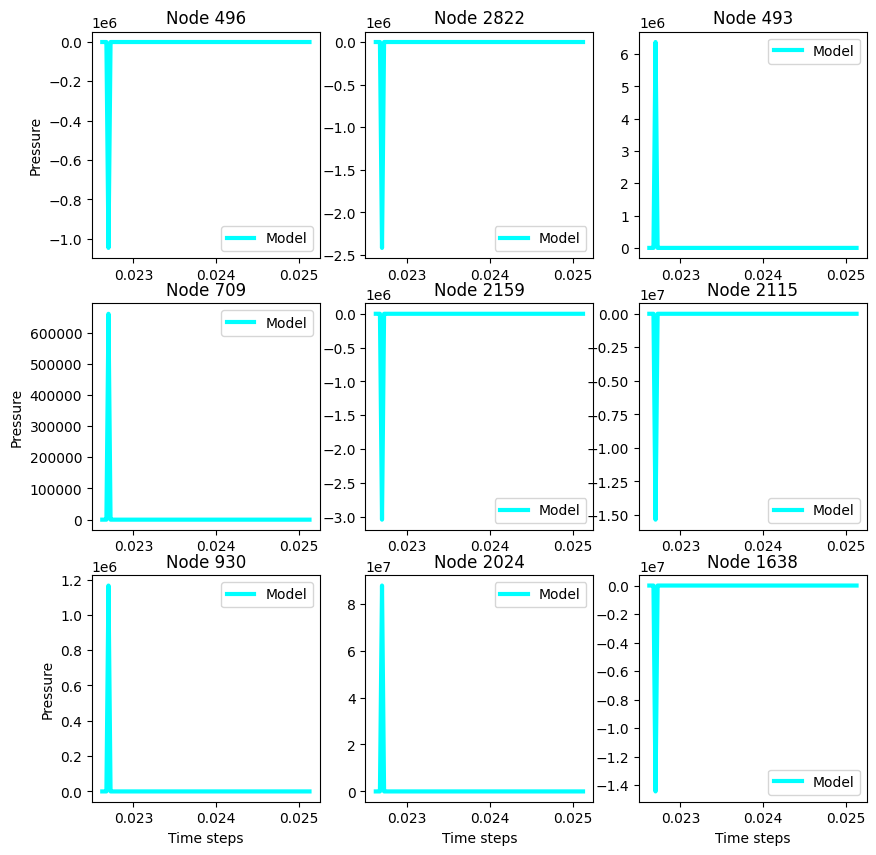

In [9]:
# choose random points in physical domain
points = random.sample(range(opInfData.shape[1]), k = 9)
# create figure. 'ax' is (3, 3) array of Axes
fig, ax = plt.subplots(3, 3, figsize = (10, 10))
# iterate in subplots
for (plotID, (axis, point)) in enumerate(zip(ax.flatten(), points)):
  axis.plot(timeTest, opInfData[-timeTest.shape[0]:, point],
    label = "Data", color = 'green', linewidth = 3
  )
  axis.plot(timeTest, reconstructIntTest[-timeTest.shape[0]:, point],
    label = "Model", color = 'cyan', linewidth = 3
  )
  axis.set_title(f"Node {point}")
  axis.legend()
  if plotID in [6, 7, 8]:
    axis.set_xlabel("Time steps")
  elif plotID in [0, 3, 6]:
    axis.set_ylabel("Pressure")
  

# Test Dataset

In [ ]:
right_operator = ClassWrapper(KS_op)
solver = LSODA(right_operator)

initial_time = time.time()
estimated_field_test = solver.run(KS_data_train[-1], t_data_test[0:1000])
elapsed_time = time.time() - initial_time
print(f"Elapsed time for time-integrating: {elapsed_time} s")

Elapsed time for time-integrating: 1.189270257949829 s


In [ ]:
# Returning to 512 dimensions

reconstructed_data_test = pipeline.reconstruct_data(data=estimated_field_test)
data_test = pipeline.reconstruct_data(data=KS_data_test)


Applying the global reconstruction strategy.
Applying the global reconstruction strategy.


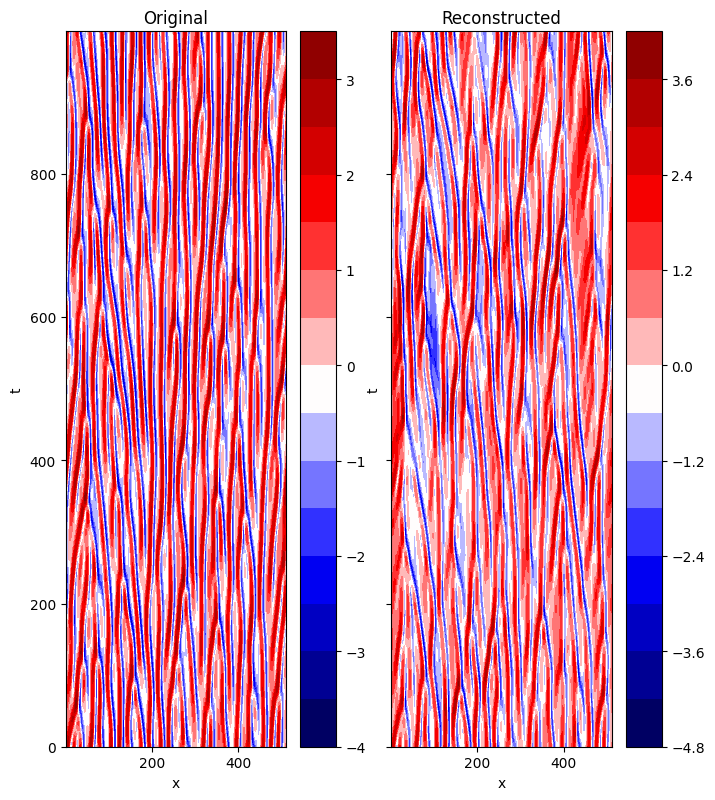

In [ ]:
# Comparing the results

compare_plot(data_test[0:1000], reconstructed_data_test[0:1000],"Original", "Reconstructed")

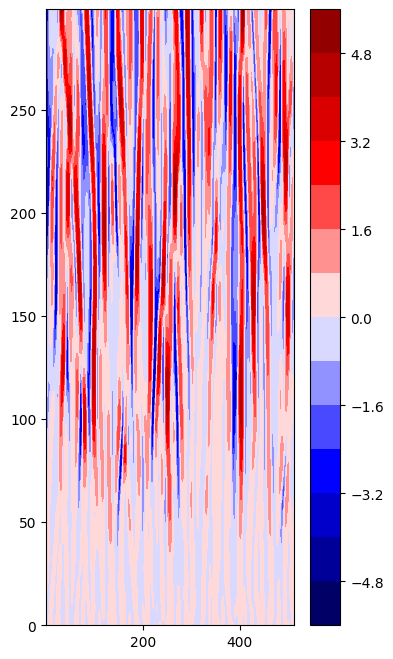

In [ ]:
#plotting the difference between the data

plot(data_test[0:300]-reconstructed_data_test[0:300])

## "View" along time

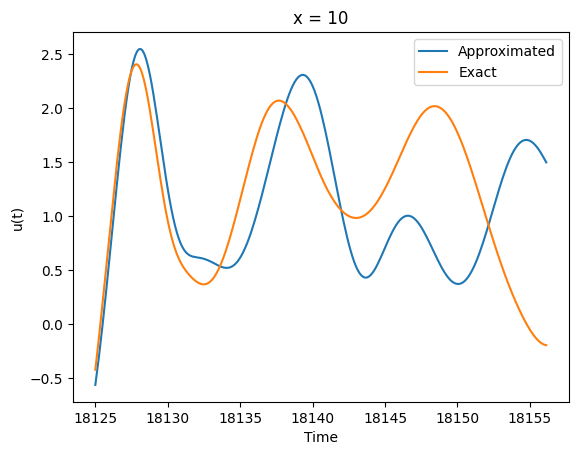

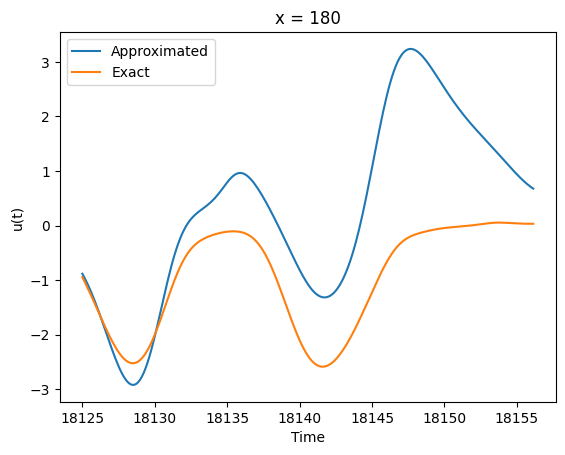

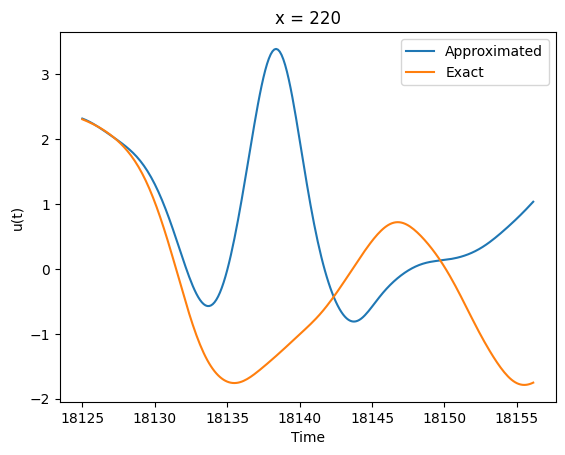

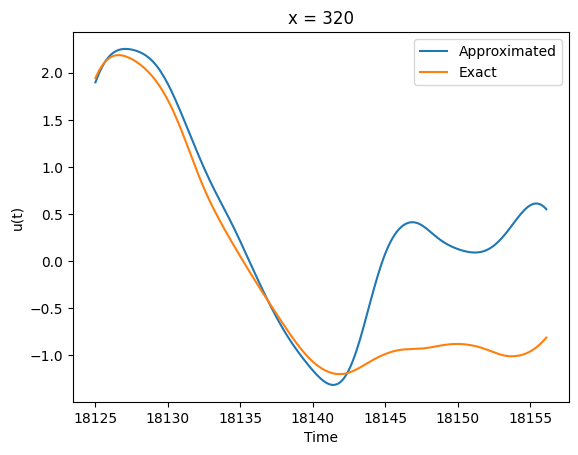

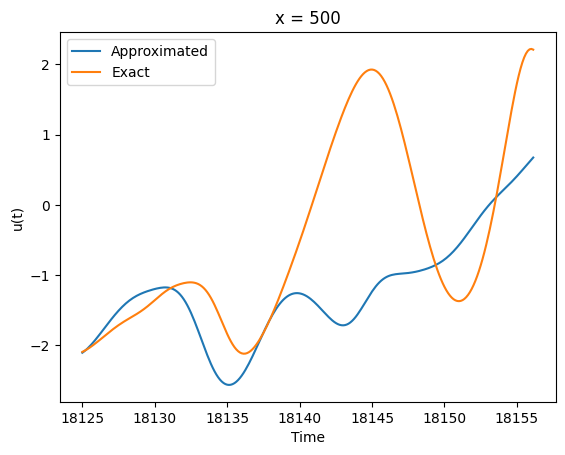

In [ ]:
start = 0
end = 250

samples = [10, 180, 220, 320, 500 ] # x values

for sample in samples:

  time_ref = t_data_test[start:end]
  x = data_test[start:end][:,sample]
  x_aprox = reconstructed_data_test[start:end][:,sample]
  plt.plot(time_ref, x_aprox, label="Approximated")
  plt.plot(time_ref, x, label="Exact")
  plt.xlabel("Time")
  plt.ylabel("u(t)")
  plt.title("x = "+ str(sample))
  plt.legend()
  plt.show()

## "View" along space

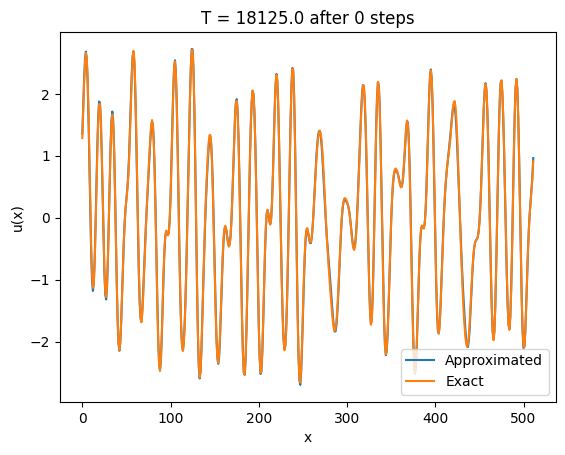

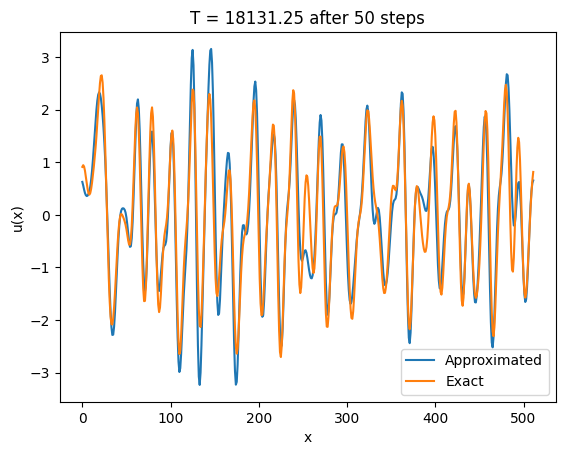

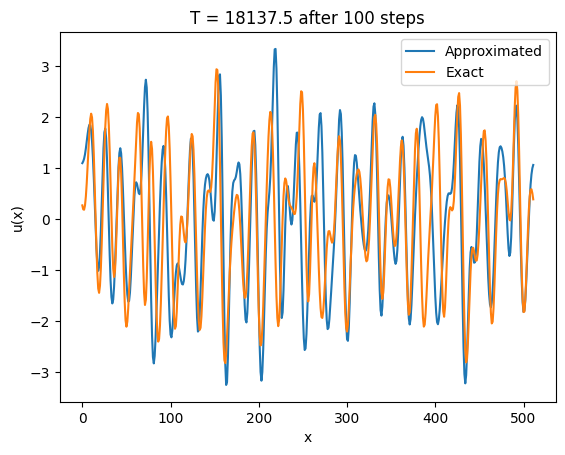

In [ ]:
samples = [0, 50, 100] # t values

for sample in samples:

  x_ref = range(512)
  x = data_test[sample,:]
  x_aprox = reconstructed_data_test[sample,:]

  plt.plot(x_ref, x_aprox, label="Approximated")
  plt.plot(x_ref, x, label="Exact")
  plt.xlabel("x")
  plt.ylabel("u(x)" )
  plt.legend()
  plt.title("T = " + str(t_data_test[sample])+" after " + str(sample) + " steps"  ) 
  plt.show()

# Conclusion

The results of this work for solving the Kuramoto-Sivashinsky problem were obtained by decomposing the initial dataset from 480000, to 150000 samples. Using 90% of the 150000 samples for training, and 10% for testing. The lambdas were chosen by error analysis. Better results can be obtained using the full dataset, which in this case was not used to minimize computational usage.